Antes de iniciar, certifique-se que obteve uma maquina com GPU ou TPU




Seguir os passos descritos aqui https://www.kaggle.com/general/74235




In [2]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Baixar e extrair os dados

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/food41
# !unzip food41.zip

In [4]:
# import os
# os.remove('food41.zip')

Separar em treino e teste de acordo com a sugestao do autor

In [5]:
import os
with open('dataset/meta/meta/train.txt') as trainfile:
    trainlines = trainfile.readlines()
    trainlines = [line.rstrip()+'.jpg' for line in trainlines]

with open('dataset/meta/meta/test.txt') as testfile:
    testlines = testfile.readlines()
    testlines = [line.rstrip()+'.jpg' for line in testlines]

# !mkdir train/
# !mkdir test/

#create directories
with open('dataset/meta/meta/classes.txt') as classfile:
    classlines = classfile.readlines()
    classlines = [line.rstrip() for line in classlines]

for class_ in classlines:
    try:
        os.makedirs('dataset/train/'+class_)
    except:
        pass
    try:
        os.makedirs('dataset/test/'+class_)
    except:
        pass

#move files to corresponding folder
for tl in trainlines:
    try:
        os.replace('dataset/images/'+tl, 'dataset/train/'+tl)
    except:
        pass
for tl in testlines:
    try:
        os.replace('dataset/images/'+tl, 'dataset/test/'+tl)
    except:
        pass

Limpa o que nao vai ser usado

In [ ]:
#clean up
for class_ in classlines:
    try:
        os.rmdir('dataset/images/'+class_)
    except:
        pass
try:
    os.rmdir('dataset/images/')
except:
    pass

Aqui comeca de fato o modelo. O codigo abaixo e apenas uma sugestao.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(
    rescale=1./255
    #insert only preprocessing functions
)

In [ ]:
train_batches = datagen.flow_from_directory('dataset/train/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))
test_batches = datagen_test.flow_from_directory('dataset/test/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Esta etapa pode gerar um problema. Se o flow from directory detectar mais de 101 classes, possivelmente existem arquivos temporarios do notebook escondidos dentro da pasta. Neste caso remover com !rm -r (train ou test)/.ipynb_checkpoints/

In [ ]:
import scipy

print(train_batches)
print(len(train_batches))
for each in train_batches:
    print(each[0].shape)
    print(each[1].shape)
    break

1184
(64, 224, 224, 3)
(64, 101)


Investigate the dataset. Is this a balanced dataset? What performance metrics are best suited for this type of dataset?

In [ ]:
print("Folders and their corresponding number of files:")
for folder in os.listdir('dataset/train'):
    folder_path = os.path.join('dataset/train', folder)
    if os.path.isdir(folder_path):
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{folder}: {num_files} files")

Folders and their corresponding number of files:
apple_pie: 750 files
baby_back_ribs: 750 files
baklava: 750 files
beef_carpaccio: 750 files
beef_tartare: 750 files
beet_salad: 750 files
beignets: 750 files
bibimbap: 750 files
bread_pudding: 750 files
breakfast_burrito: 750 files
bruschetta: 750 files
caesar_salad: 750 files
cannoli: 750 files
caprese_salad: 750 files
carrot_cake: 750 files
ceviche: 750 files
cheesecake: 750 files
cheese_plate: 750 files
chicken_curry: 750 files
chicken_quesadilla: 750 files
chicken_wings: 750 files
chocolate_cake: 750 files
chocolate_mousse: 750 files
churros: 750 files
clam_chowder: 750 files
club_sandwich: 750 files
crab_cakes: 750 files
creme_brulee: 750 files
croque_madame: 750 files
cup_cakes: 750 files
deviled_eggs: 750 files
donuts: 750 files
dumplings: 750 files
edamame: 750 files
eggs_benedict: 750 files
escargots: 750 files
falafel: 750 files
filet_mignon: 750 files
fish_and_chips: 750 files
foie_gras: 750 files
french_fries: 750 files
frenc

This dataset is balanced, and the performance metric to be used is going to be acurracy.

Develop a Convolutional Neural Network architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_batches[0][0].shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_batches.class_indices), activation='softmax'))
# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Display the model summary
model.summary()



NameError: name 'train_batches' is not defined

In [ ]:
import tensorflow.compat.v1 as tf 

tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 

print(tf.add([1.0, 2.0], [3.0, 4.0])) 

tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [15]:
import tensorflow as tf
# Fit the model2 to the data with augmented training data
with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch = 75750/64,
        epochs=1,
        validation_data = test_batches, #create a validation set if needed
        validation_steps= 25250/64,
        # use_multiprocessing=True,
        workers=8,
        max_queue_size=512,
    )

: 

Daqui para baixo, podem ser gerados os resultados. A variavel hist pode ser usada para plotar as curvas. Para obter as predicoes, usar model.predict(test_batches). Matrizes de confusao e metricas podem ser facilmente calculadas usando o pacote scikit-learn.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

395/395 [==============================] - 47s 119ms/step - loss: 3.5566 - accuracy: 0.1692
Test Accuracy: 16.92%


In [ ]:
model.save_weights('first_try.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


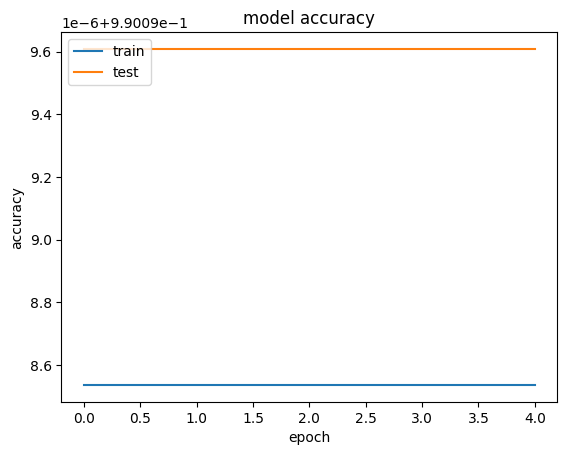

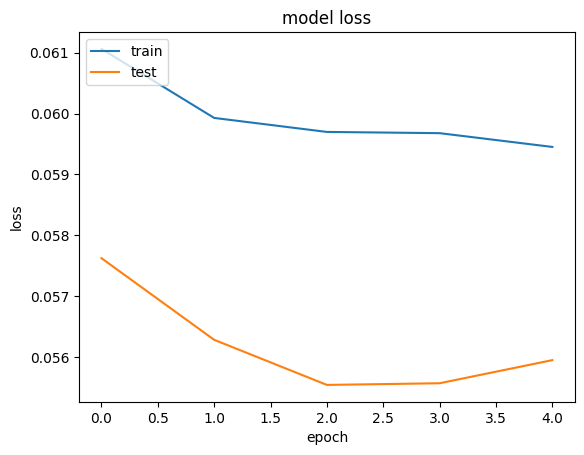

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()